# Standard Bank Tech Impact Challenge: Animal classification

The objective of this challenge is to create a machine learning model to accurately predict the likelihood that an image contains a zebra, as opposed to an elephant. While this may be an easy task for humans, elephants, and zebras, your computer will find it a bit more difficult.

The total dataset contains 13,999 images of zebras and elephants, sampled from the Snapshot Serengeti collection of more than 6 million animals.

Your task is to predict whether a given image contains a zebra or elephant. For each unique image ID in the test set you should estimate the likelihood that the image contains a zebra or elephant, with an estimated probability value between 0 and 1. A value of 1 represents a zebra and 0 represents an elephant. These images do not contain both simultaneously. It is therefore only a binary classification task.

### Dataset:
You are given 13,999 photos each with a unique identifier. The data is given in jpeg format. Each photo has already been resized to 330x330 pixels.

### Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [3]:
tf.__version__

'2.3.0'

## Part 1 - Data Augmentation & Preprocessing

Data augmentation is an essential way to fight overfitting for computer vision models.
In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that at training time, our model will never see the exact same picture twice. This helps prevent overfitting and helps the model generalize better. 

This can be done by configuring a number of random transformations to be performed on the images read by our ImageDataGenerator instance.

In [4]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

Above you will find a few of the options available for augmenting the images in your dataset with ImageDataGenerator.

- rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
- width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
- shear_range is for randomly applying shearing transformations.
- zoom_range is for randomly zooming inside pictures.
- horizontal_flip is for randomly flipping half of the images horizontally. This is relevant when there are no assumptions of horizontal assymmetry (e.g. real-world pictures).
- fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

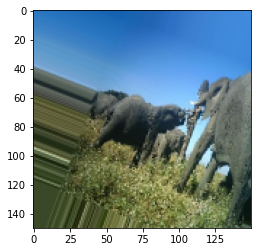

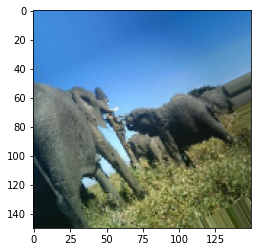

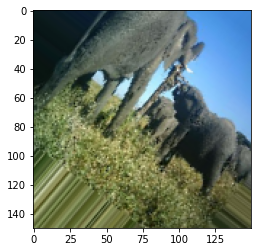

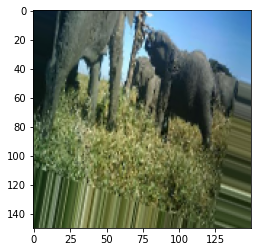

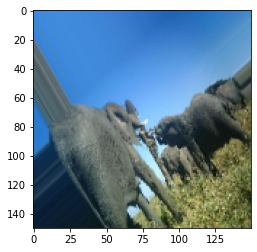

In [17]:
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
import os

base_dir = 'C:/Users/User/Documents/Varisty/Masters/Techpreneurship Program/Assignments/Final Project/dataset/'
direc = os.path.join(base_dir, 'Train')
train_el_dir = os.path.join(direc, 'elephants')
elephants = os.listdir(train_el_dir)

img_path = os.path.join(train_el_dir, elephants[2])

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# The .flow() command below generates batches of randomly transformed images. It loops indefinitely, so we need to include a `break` the loop.
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 5 == 0:
        break

### Preprocessing the Training set

In [20]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
training_set = train_datagen.flow_from_directory(
        directory=direc,
        target_size=(64,64),
        batch_size=32,
        class_mode='binary')

Found 9999 images belonging to 2 classes.


### Preprocessing the validation set

In [21]:
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_direc = os.path.join(base_dir, 'Valid')

validation_set = valid_datagen.flow_from_directory(
    directory=valid_direc,
    target_size=(64,64),
    batch_size=32,
    class_mode = 'binary')

Found 2000 images belonging to 2 classes.


### Preprocessing the Test set

In [22]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_direc = os.path.join(base_dir, 'Test')

test_set = test_datagen.flow_from_directory(
        directory=test_direc,
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary',
        seed=42)

Found 2000 images belonging to 2 classes.


## Part 2 - Building the CNN

### Initialising the CNN

In [23]:
cnn = tf.keras.models.Sequential()

### Step 1 - Convolution

In [24]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))

### Step 2 - Pooling

In [25]:
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

### Adding a second convolutional layer

In [26]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

### Step 3 - Flattening

In [27]:
cnn.add(tf.keras.layers.Flatten())

### Step 4 - Full Connection

In [28]:
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

### Step 5 - Output Layer

In [29]:
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

## Part 3 - Training the CNN

### Compiling the CNN

In [30]:
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Training the CNN on the Training set and evaluating it on the Test set

In [ ]:
cnn.fit(training_set, validation_data = validation_set, epochs = 25)

## Part 4 - Making a single prediction

In [ ]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('dataset/single_prediction/cat_or_dog_1.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)
training_set.class_indices
if result[0][0] == 1:
  prediction = 'dog'
else:
  prediction = 'cat'

In [ ]:
print(prediction)